# Natural language inference

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2016 term"

## Contents

0. [Overview](#Overview)
0. [Set-up](#Set-up)
0. [Working with SNLI](#Working-with-SNLI)
   0. [Trees](#Trees)
   0. [Readers](#Readers)
0. [Linear classifier approach](#Linear-classifier-approach)
   0. [Baseline linear classifier features](#Baseline-linear-classifier-features)
   0. [Building datasets for linear classifier experiments](#Building-datasets-for-linear-classifier-experiments)
   0. [Training linear classifiers](#Training-linear-classifiers)
   0. [Running linear classifier experiments](#Running-linear-classifier-experiments)
0. [Recurrent neural network approach](#Recurrent-neural-network-approach)
   0. [Classifier RNN model definition](#Classifier-RNN-model-definition)
   0. [Building datasets for classifier RNNs](#Building-datasets-for-classifier-RNNs)
   0. [Running classifier RNN experiments](#Running-classifier-RNN-experiments)
   0. [Next steps for NLI deep learning models](#Next-steps-for-NLI-deep-learning-models)
0. [Additional NLI resources](#Additional-NLI-resources)
0. [Homework 4](#Homework-4)

## Overview

Natural Language Inference (NLI) is the task of predicting the logical relationships between words, phrases, sentences, (paragraphs, documents, ...). Such relationships are crucial for all kinds of reasoning in natural language: arguing, debating, problem solving, summarization, and so forth. 

Our NLI data will look like this:

* (_every dog danced_, _every puppy moved_) $\Rightarrow$ __entailment__
* (_a puppy danced_, _no dog moved_) $\Rightarrow$ __contradiction__
* (_a dog moved_, _no puppy danced_) $\Rightarrow$ __neutral__

The first sentence is the __premise__ and the second is the __hypothesis__ (logicians call it the __conclusion__).

We looked at NLI briefly in our word-level entailment bake-off (the [wordentail.ipynb](wordentail.ipynb) notebook). The purpose of this codebook is to introduce the problem of NLI more fully in the context of the [Stanford Natural Language Inference](http://nlp.stanford.edu/projects/snli/) corpus (SNLI). We'll explore two general approaches:

* Standard linear classifiers
* Recurrent neural networks

This should be a good starting point for exploring richer models of NLI. It's also fun because it sets up a battle royale between models that require serious linguistic analysis (the linear ones) and models that are claimed by advocates to require no such analysis (deep learning).

In [2]:
import os
import re
import sys
import pickle
import numpy as np
import itertools
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import utils
from nltk.tree import Tree
from nli_rnn import ClassifierRNN

In [3]:
%config InlineBackend.figure_formats=['svg']

## Set-up

0. Make sure your environment includes all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u).
0. Make sure `snli_sample_src` (just below) is pointing to your copy of `snli_1.0_cs224u_sample.pickle`, which should be included in the repository in the `nli-data` subfolder. (Because SNLI is very large, we'll work with a small sample from the training set in class.)
0. For the homework: make sure you've run `nltk.download()` to get the NLTK data. (In particular, you need to use NLTK's WordNet API.)

In [4]:
# Home for our SNLI sample:
snli_sample_src = os.path.join('nli-data', 'snli_1.0_cs224u_sample.pickle')

# Load the dataset: a dict with keys `train`, `dev`, and `vocab`. The first
# two are lists of `dict`s sampled from the SNLI JSONL files. The third is
# the complete vocabulary of the leaves in the trees for `train` and `dev`.
snli_sample = pickle.load(open(snli_sample_src, 'rb'))

snli_sample.keys()

['vocab', u'train', u'dev']

## Working with SNLI

SNLI contains both regular string representations of the data and unlabeled binary parses like the following:

`
( ( A child ) ( is ( playing ( in ( a yard ) ) ) ) )
`

The brackets encode a label-free constituency structure of each sentence. 

Here are the class labels that we wish to learn to predict:

In [5]:
LABELS = ['contradiction', 'entailment', 'neutral']

The training set for SNLI contains 550,152 sentence pairs, with sentences varying in length from 2 to 62 words. This is too large for in-class experiments and assignments. This is why we're working with the sample in `snli_sample`:

In [6]:
len(snli_sample['train'])

9000

In [7]:
len(snli_sample['dev'])

1500

In [8]:
len(snli_sample['vocab'])

6367

Both `train` and `test` are balanced across the three classes, with sentences varying in length from 3 to 6 words. These limitations will allow us to explore lots of different models in class. You're encouraged to try out your ideas on the full dataset outside of class (perhaps as part of your final project).

### Trees

The following function can be used to turn bracketed strings like the above into trees:

In [9]:
def str2tree(s):
    """Map str `s` to an `nltk.tree.Tree` instance. The assumption is that 
    `s` represents a tree with no node labels. We add a nonce label 'X'
    for compatibility with `Tree.fromstring`."""
    s = s.replace("(", "(X")
    return Tree.fromstring(s)    

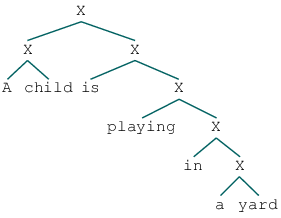

In [10]:
t = str2tree("( ( A child ) ( is ( playing ( in ( a yard ) ) ) ) )")
t

For baseline models, we often want just the words, also called terminal nodes or _leaves_. We can access them with the `leaves` method on `nltk.tree.Tree` instances:

In [11]:
t.leaves()

['A', 'child', 'is', 'playing', 'in', 'a', 'yard']

### Readers

To make it easy to run through the corpus, let's define general readers for the data. The general function for this yields triples consisting of the the left tree and the right tree, as parsed by `str2tree`, and finally the label:

In [12]:
def snli_reader(sample):
    """Reader for SNLI data. `sample` just needs to be an iterator over
    the SNLI JSONL files. For this notebook, it will always be 
    `snli_sample`, but, for example, the following should work for the 
    corpus files:
    
    import json    
    def sample(src_filename):
        for line in open(src_filename):
            yield json.loads(line)
    
    Yields
    ------
    tuple
        (tree1, tree2, label), where the trees are from `str2tree` and
        label is in `LABELS` above.
      
    """
    for d in sample:
        yield (str2tree(d['sentence1_binary_parse']), 
               str2tree(d['sentence2_binary_parse']),
               d['gold_label'])
        
def train_reader():
    """Convenience function for reading just the training data."""
    return snli_reader(snli_sample['train'])

def dev_reader():
    """Convenience function for reading just the dev data."""
    return snli_reader(snli_sample['dev'])

## Linear classifier approach

To start, we'll adopt an approach that is essentially identical to that of the [supervisedsentiment.ipynb](supervisedsentiment.ipynb) notebook: we'll train simple MaxEnt classifiers on representations of the data obtained from hand-built feature functions. 

This notebook defines some common baseline features based on pairings of information in the premise and hypothesis. As usual, one can realize big performance gains quickly by improving on these baseline representations.

### Baseline linear classifier features

The first baseline we define is the _word overlap_ baseline. It simply uses as
features the words that appear in both sentences.

In [13]:
def word_overlap_phi(t1, t2):    
    """Basis for features for the words in both the premise and hypothesis.
    This tends to produce very sparse representations.
    
    Parameters
    ----------
    t1, t2 : `nltk.tree.Tree`
        As given by `str2tree`.
        
    Returns
    -------
    defaultdict
       Maps each word in both `t1` and `t2` to 1.
    
    """
    overlap = set([w1 for w1 in t1.leaves() if w1 in t2.leaves()])
    return Counter(overlap)

Another popular baseline is  the full cross-product of words from both sentences:    

In [14]:
def word_cross_product_phi(t1, t2):
    """Basis for cross-product features. This tends to produce pretty 
    dense representations.
    
    Parameters
    ----------
    t1, t2 : `nltk.tree.Tree`
        As given by `str2tree`.
        
    Returns
    -------
    defaultdict
        Maps each (w1, w2) in the cross-product of `t1.leaves()` and 
        `t2.leaves()` to its count. This is a multi-set cross-product
        (repetitions matter).
    
    """
    return Counter([(w1, w2) for w1, w2 in itertools.product(t1.leaves(), t2.leaves())])

Both of these feature functions return count dictionaries mapping feature names to  the number of times they occur in the data. This is the representation we'll work with throughout; `sklearn` will handle the further processing it needs to build linear classifiers.

Naturally, you can do better than these feature functions! Both of these  might be useful even in a more advanced model, though.

### Building datasets for linear classifier experiments

As usual, the first step in training a classifier is using a feature function like the one above to turn the data into a list of training instances (feature representations and their associated labels):

In [15]:
def build_linear_classifier_dataset(
        reader, 
        phi=word_overlap_phi, 
        vectorizer=None):
    """Create a dataset for training classifiers using `sklearn`.
    
    Parameters
    ----------
    reader
        An SNLI iterator like `snli_reader` above. Just needs to
        yield (tree, tree, label) triples.
        
    phi : feature function
        Maps trees to count dictionaries.
        
    vectorizer : `sklearn.feature_extraction.DictVectorizer`   
        If this is None, then a new `DictVectorizer` is created and
        used to turn the list of dicts created by `phi` into a 
        feature matrix. This happens when we are training.
              
        If this is not None, then it's assumed to be a `DictVectorizer` 
        and used to transform the list of dicts. This happens in 
        assessment, when we take in new instances and need to 
        featurize them as we did in training.
        
    Returns
    -------
    dict
        A dict with keys 'X' (the feature matrix), 'y' (the list of
        labels), 'vectorizer' (the `DictVectorizer`), and 
        'raw_examples' (the original tree pairs, for error analysis).
    
    """
    feat_dicts = []
    labels = []
    raw_examples = []
    for t1, t2, label in reader():
        d = phi(t1, t2)
        feat_dicts.append(d)
        labels.append(label)   
        raw_examples.append((t1, t2))
    if vectorizer == None:
        vectorizer = DictVectorizer(sparse=True)
        feat_matrix = vectorizer.fit_transform(feat_dicts)
    else:
        feat_matrix = vectorizer.transform(feat_dicts)
    return {'X': feat_matrix, 
            'y': labels, 
            'vectorizer': vectorizer, 
            'raw_examples': raw_examples}

### Training linear classifiers

To keep this notebook relatively simple, we adopt a bare-bones training framework, using just a standard-issue MaxEnt classifier. The following function is from [supervisedsentiment.ipynb](supervisedsentiment.ipynb):

In [16]:
def fit_maxent_classifier(X, y):    
    """Wrapper for `sklearn.linear.model.LogisticRegression`. This is also 
    called a Maximum Entropy (MaxEnt) Classifier, which is more fitting 
    for the multiclass case.
    
    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.
        
    y : list
        The list of labels for rows in `X`.
    
    Returns
    -------
    `sklearn.linear.model.LogisticRegression`
        A trained `LogisticRegression` instance.
    
    """
    mod = LogisticRegression(fit_intercept=True)
    mod.fit(X, y)
    return mod

For a more robust and responsible approach, see [supervisedsentiment.ipynb](supervisedsentiment.ipynb) notebook, especially the [section on hyperparameter search](supervisedsentiment.ipynb#Hyperparameter-search).

### Running linear classifier experiments

The `linear_classifier_experiment` function handles the book-keeping associated with running experiments. It essentially just combines all of the above pieces in a flexible way. If you decide to expand this codebase for real experiments, then you'll likely want to incorporate more of the functionality from the [supervisedsentiment.ipynb](supervisedsentiment.ipynb) notebook, especially [its method for comparing different models statistically](supervisedsentiment.ipynb#Statistical-comparison-of-classifier-models).

In [17]:
def linear_classifier_experiment(
        train_reader=train_reader, 
        assess_reader=dev_reader, 
        phi=word_overlap_phi,
        train_func=fit_maxent_classifier):  
    """Runs experiments on our SNLI fragment.
    
    Parameters
    ----------
    train_reader, assess_reader
        SNLI iterators like `snli_reader` above. Just needs to
        yield (tree, tree, label) triples.
        
    phi : feature function (default: `word_overlap_phi`)
        Maps trees to count dictionaries.
        
    train_func : model wrapper (default: `fit_maxent_classifier`)
        Any function that takes a feature matrix and a label list
        as its values and returns a fitted model with a `predict`
        function that operates on feature matrices.
    
    Returns
    -------
    str
        A formatted `classification_report` from `sklearn`.
        
    """
    train = build_linear_classifier_dataset(train_reader, phi)    
    assess = build_linear_classifier_dataset(assess_reader, phi, vectorizer=train['vectorizer'])
    mod = fit_maxent_classifier(train['X'], train['y'])
    predictions = mod.predict(assess['X'])
    return classification_report(assess['y'], predictions)

In [18]:
print(linear_classifier_experiment())

             precision    recall  f1-score   support

contradiction       0.38      0.49      0.42       500
 entailment       0.43      0.34      0.38       500
    neutral       0.32      0.30      0.31       500

avg / total       0.38      0.38      0.37      1500



In [19]:
print(linear_classifier_experiment(phi=word_cross_product_phi))

             precision    recall  f1-score   support

contradiction       0.56      0.49      0.52       500
 entailment       0.48      0.55      0.52       500
    neutral       0.44      0.43      0.44       500

avg / total       0.49      0.49      0.49      1500



### A few ideas for better classifier features

* Cross product of synsets compatible with each word, as given by WordNet. (Here is [a codebook on using WordNet from NLTK to do things like this](http://compprag.christopherpotts.net/wordnet.html).)

* More fine-grained WordNet features &mdash; e.g., spotting pairs like _puppy_/_dog_ across the two sentences.

* Use of other WordNet relations (see Table 1 and Table 2 in [this codelab](http://compprag.christopherpotts.net/wordnet.html) for relations and their coverage).

* Using the tree structure to define features that are sensitive to how negation scopes over constituents.

* Features that are sensitive to differences in negation between the two sentences.

* Sentiment features seeking to identify contrasting sentiment polarity.

## Recurrent neural network approach

Very recently, recurrent neural networks (RNNs) have become one of the dominant approaches to NLI, and there is a great deal of interest in the extent to which they can learn to simulate the powerful symbolic approaches that have long dominated work in NLI. 

The goal of this section is to give you some hands-on experience with using RNNs to build NLI models. Because these models are demanding not only in terms of data but also in terms of training time, we'll just get a glimpse of their potential, but I think even this glimpse clearly indicates their great potential.

### Classifier RNN model definition

The model we'll be exploring is probably the simplest one that fits the NLI problem. It's depicted in the following diagram:

<img src="fig/nli-rnn.svg" width="700" />

This model would actually work for any classification task. For instance, you could revisit the [supervisedsentiment](supervisedsentiment.ipydb) notebook and try it out on the Stanford Sentiment Treebank.

The dominant applications for RNNs to date have been for language modeling and machine translation. Those models have many more output vectors than ours. For a wonderful step-by-step introduction to such models, see Denny Britz's [four-part tutorial](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) (in the form of a notebook like this one). See also Andrej Karpathy's [insightful, clear overview of different RNN architectures](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). (Both Denny and Andrej are Stanford researchers!)

The above diagram is a kind of schematic for the following model definition:

$$h_{t} = \tanh\left(x_{t}W_{xh} + h_{t-1}W_{hh}\right)$$

$$y = \text{softmax}\left(h_{n}W_{hy}\right)$$

where $n$ is the sequence length and $1 \leqslant t \leqslant n$. As indicated in the above diagram, the sequence of hidden states is padded with an initial state $h_{0}$. In our implementation, this is always an all $0$ vector, but it can be initialized in more sophisticated ways.

It's important to see that there is just one $W_{xh}$, just one $W_{hh}$, and just one $W_{hy}$. 

Our from-scratch implementation of the above model is in [nli_rnn.py](nli_rnn.py). As usual, the goal of this code is to illuminate the above concepts and clear up any lingering underspecification in descriptions like the above. The code also shows how __backpropagation through time__ works in these models. You'll see that it is very similar to regular backpropagation as we used it in the simpler [word-entailment bake-off](wordentail.ipynb) (using the feed-forward networks from [shallow_neural_networks.py](shallow_neural_networks.py).)

### Building datasets for classifier RNNs

The following function uses our `snli_reader` infrastructure to create datasets for training and assessing RNNs. The steps:

* Concatenate the leaves of the premise and hypothesis trees into a sequence
* Use the `LABELS` vector defined above to turn each string label into a one-hot vector.

In [20]:
def build_rnn_dataset(reader):
    """Build RNN datasets.
    
    Parameters
    ----------
    reader
        SNLI iterator like `snli_reader` above. Just needs to
        yield (tree, tree, label) triples.
        
    Returns
    -------
    list of tuples
        The first member of each tuple is a list of strings (the
        concatenated leaves) and the second is an np.array 
        (dimension 3) with a single 1 for the true class and 0s
        in the other two positions
       
    """    
    dataset = []
    for (t1, t2, label) in reader():
        seq = t1.leaves() + t2.leaves()
        y_ = np.zeros(3)
        y_[LABELS.index(label)] = 1.0
        dataset.append((seq, y_))
    return dataset

### Running classifier RNN experiments

Nex we define functions for the training and assessment steps. It's currently baked in that you want to train with `train_reader` and assess on `dev_reader`. If you start doing serious experiments, you'll want to move to a more flexible set-up like the one we established above for linear classifiers (and see [supervisedsentiment.ipynb](supervisedsentiment.ipynb) for even more ideas).

The important thing to see about this function is that it requires a `vocab` argument and an `embedding` argument:

* `vocab` is a list of strings. It needs to contain every word we'll encounter in training or assessment.
* `embedding` is a 2d matrix in which the ith row gives the input representation for the ith member of `vocab`.

This gives you flexibility in how you represent the inputs. In the experiment run below, the inputs are just random vectors, but [the homework](#Homework-4) asks you to try out GloVe inputs.

In [21]:
def rnn_experiment(
        vocab, 
        embedding, 
        hidden_dim=10, 
        eta=0.05, 
        maxiter=10):
    """Classifier RNN experiments.
    
    Parameters
    ----------
    vocab : list of str
        Must contain every word we'll encounter in training or assessment.
        
    embedding : np.array
        Embedding matrix for `vocab`. The ith row gives the input 
        representation for the ith member of vocab. Thus, `embedding`
        must have the same row count as the length of vocab. Its
        columns can be any length. (That is, the input word 
        representations can be any length.)
        
    hidden_dim : int (default: 10)
        Dimensionality of the hidden representations. This is a
        parameter to `ClassifierRNN`.
        
    eta : float (default: 0.05)
        The learning rate. This is a parameter to `ClassifierRNN`.       
        
    maxiter : int (default: 10)
        Maximum number of training epochs. This is a parameter 
        to `ClassifierRNN`.       
        
    Returns
    -------
    str
        A formatted `sklearn` `classification_report`.
    
    """
    # Training:
    train = build_rnn_dataset(train_reader)       
    mod = ClassifierRNN(
        vocab, 
        embedding, 
        hidden_dim=hidden_dim, 
        eta=eta,
        maxiter=maxiter)
    mod.fit(train)    
    # Assessment:
    assess = build_rnn_dataset(dev_reader) 
    return rnn_model_evaluation(mod, assess)

In [22]:
def rnn_model_evaluation(mod, assess):
    """Asssess a trained `ClassifierRNN`.
    
    Parameters
    ----------
    mod : `ClassifierRNN`
        Should be a model trained on data in the same format as
        `assess`.
    
    assess : list
        A list of (seq, label) pairs, where seq is a sequence of
        words and label is a one-hot vector giving the label.        
    
    """    
    # Assessment:
    gold = []
    predictions = []    
    for seq, y_ in assess:
        # The gold labels are vectors. Get the index of the single 1
        # and look up its string in `LABELS`:
        gold.append(LABELS[np.argmax(y_)])
        # `predict` returns the index of the highest score.
        p = mod.predict(seq) 
        predictions.append(LABELS[p])
    # Report:
    return classification_report(gold, predictions)

Here's an example run. All input and hidden dimensions are quite small, as is `maxiter`. This is just so you can run experiments quickly and see what happens. Nonetheless, the performance is competitive with the linear classifier above, which is encouraging about this approach.

In [23]:
vocab = snli_sample['vocab']

# Random embeddings of dimension 10:
randvec_embedding = np.array([utils.randvec(10) for w in vocab])

# A small network, trained for just a few epochs to see how things look:
print(rnn_experiment(vocab, randvec_embedding, hidden_dim=10, eta=0.001, maxiter=100))

Finished epoch 100 of 100; error is 1.08155358503

             precision    recall  f1-score   support

contradiction       0.36      0.25      0.29       500
 entailment       0.40      0.59      0.47       500
    neutral       0.40      0.34      0.37       500

avg / total       0.39      0.39      0.38      1500



### Next steps for NLI deep learning models

As noted above, `ClassifierRNN` is just about the simplest model we could use for this task. Some thoughts on where to take it:

* Additional hidden layers can be added. This is a relatively simple change to the code: one just needs to define a version of $W_{hh}$ for each layer, respecting the desired dimensions for the  representations of the layers it connects. The backpropagation steps are also straightforward duplications of what happens between the current layers.

* `ClassifierRNN` uses the most basic (non-linear) activation functions. In TensorFlow, it is easy to try more advanced designs, including Long Short-Term Memory (LSTM) cells and Gated Recurrent Unit (GRU) cells. The documentation for these is currently a bit hard to find, but here's [the well-documented source code](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell.py).

* The [SNLI leaderboard](http://nlp.stanford.edu/projects/snli/) shows the value of adding __attention__ layers. These are additional connections between premise and hypothesis. They can be made for each pair of words or just for the final hidden representation in the premise and hypothesis.

* We haven't made good use of trees. Like many linguists, I believe trees are necessary for capturing the nuanced ways in which we reason in language, and [this new paper](http://arxiv.org/abs/1603.06021) offers  empirical evidence that trees are important for SNLI. Tree-structured neural networks are by now well-understood extensions of feed-forward neural networks and so are well within reach for a final project.

## Additional NLI resources

* Do get [the full SNLI](http://nlp.stanford.edu/projects/snli/) and figure out how to grapple with its large size! Here's [a useful and insightful blog post by Sam Bowman on SNLI's design](http://nlp.stanford.edu/blog/the-stanford-nli-corpus-revisited/).

* The folder [nli-data](nli-data) in this repository contains the NLI data from the [SemEval 2014 semantic relatedness task](http://alt.qcri.org/semeval2014/task1/). 
This data set is called "Sentences Involving Compositional Knowledge" or, for better or worse, 
"SICK". It's [freely available from the SemEval site](http://alt.qcri.org/semeval2014/task1/index.php?id=data-and-tools).  [nli-data](nli-data) contains a parsed version created by [Sam Bowman](http://stanford.edu/~sbowman/) 
as part of [his research on neural models of semantic composition](https://github.com/sleepinyourhat/vector-entailment/releases/tag/W15-R1). 

* [SemEval 2013](https://www.cs.york.ac.uk/semeval-2013/) also had a wide range of interesting data sets for NLI and related tasks.

* The [FraCaS textual inference test suite](http://www-nlp.stanford.edu/~wcmac/downloads/) is a smaller, hand-built dataset that is great for evaluating a model's ability to handle complex logical patterns.

* Models for NLI might be adapted for use with the [30M Factoid Question-Answer Corpus](http://agarciaduran.org).

* Models for NLI might be adapted for use with the [Penn Paraphrase Database](http://paraphrase.org).

## Homework 4

### 1. WordNet-based entailment features [4 points]

[Python NLTK](http://www.nltk.org) has an excellent WordNet interface. As noted above, WordNet is a natural choice for defining useful features in the context of NLI.

__Your task__: write and submit a feature function, for use with `build_linear_classifier_dataset`, that is just like `word_cross_product_phi` except that, given a sentence pair $(S_{1}, S_{2})$, it counts only pairs $(w_{1}, w_{2})$ such that $w_{1}$ entails $w_{2}$, for $w_{1} \in S_{1}$ and $w_{2} \in S_{2}$. For example, the sentence pair (_the cat runs_, _the animal moves_) would create the dictionary `{(cat, animal): 1.0, (runs, moves): 1.0}`.

There are many ways to do this. For the purposes of the question, we can limit attention to the WordNet hypernym relation. The following illustrates reasonable ways to go from a string $s$ to the set of all hypernyms of Synsets consistent with $s$:

In [24]:
from nltk.corpus import wordnet as wn
    
puppies = wn.synsets('puppy')
print([h for ss in puppies for h in ss.hypernyms()])

# A more conservative approach uses just the first-listed 
# Synset, which should be the most frequent sense:
print(wn.synsets('puppy')[0].hypernyms())

[Synset('dog.n.01'), Synset('pup.n.01'), Synset('young_person.n.01')]
[Synset('dog.n.01'), Synset('pup.n.01')]


### 2. Pretrained RNN inputs [2 points]

In the simple RNN experiment above, we used random input vectors. In the [word-entailment bake-off](wordentail.ipynb), pretraining was clearly beneficial. What are the effects of using pretrained inputs here?

__Submit__:

0. A function `build_glove_embedding` that creates an embedding space for all of the words in `snli_sample['vocab']`.  (You can use any GloVe file you like; the `50d` one will be fastest.) See `randvec_embedding` above if you need further guidance on the nature of the data structure to produce. If you encounter any words in `snli_sample['vocab']` that are not in GloVe, have your function map them instead to a random vector of the appropriate dimensionality (see `utils.randvec`).

0. A function call for `rnn_experiment` using your GloVe embedding. (You can set the other parameters to `rnn_experiment` however you like.)

0. The output of this function. (You won't be evaluated by how strong the performance is. We're just curious.)

You can use `utils.glove2dict` to read in the GloVe data into a `dict`.

### 3. Simulating a propositional logic theorem prover [4 points]

Can our simple RNN learn to simulate a propositional logic theorem prover? This gets at the more general question of the extent to which deep learning models can learn to simulate symbolic systems.

The file `pl_theorems.pickle` contains triples of the form $(\varphi, \psi, y)$, where $\varphi$ and $\psi$ are propositional logic formulae and $y$ is `entailment`, `contradiction`, or `neutral`, just as in our SNLI task. In this case, the label is determined by the model theory of propositional logic. The triples look like this:

`("(p&q)", "p", 'entailment')`

`("~p", "(p&q)", 'contradiction')`

`("~p", "(p|q)", 'neutral')`

Using simulated data in this way gives us a  clear learning target.

__Submit__:

0. A function `pl_splits` that randomly splits the contents of `pl_theorems.pickle` into a train set and a test set. Be sure to attend to the labels &ndash; they need to be turned from strings into one-hot vectors (see `build_rnn_dataset` above for the method).

0. A function `pl_rnn_experiment`, comparable to `rnn_experiment`, that uses your splits to train and assess a `ClassifierRNN`. Some notes and requirements for this:

  * The formulae are designed so that each character is a meaningful unit. So `list(phi)` is the list of "words" in the formula `phi`.
  * Use `rnn_model_evaluation` for assessment.
  * You can use random embeddings. 
  * It's probably good to give the user control over important model hyperparameters like `eta`, `hidden_dim`, the dimensionality of the inputs, etc. This isn't required, though.
  
__Practical note__: Be sure to set `eta` low. High values often lead to unstable learning for this problem.

__Conceptual note__: the formulae have a clear tree structure, as indicated by their bracketing, but we are processing them as a strings. Part of what we are assessing is the extent to which this purely sequence-based model can learn that the brackets indicate subformulae, and keep track of how those subformulae are delimited.

Here's some code to help you structure your answer:

In [25]:
from sklearn.cross_validation import train_test_split

# Loads the data:
pl = pickle.load(open('pl_theorems.pickle', 'rb'))

# The connectives:
NEG = "~"
AND = "&"
OR = "|"
IMPLIES = "<"
IFF = "="

# The full vocabulary:
pl_vocab = [NEG, AND, OR, IMPLIES, IFF, "(", ")", "p", "q"]    

def pl_splits(pl, train_size=0.7):
    """Randomly divide `pl` into train and test sets based on `train_size`"""
    dataset = []    
    # Build the dataset as required by `ClassifierRNN`:
    
    # Rely on `sklearn` for the random split:
    train, assess = train_test_split(dataset, train_size=train_size)                        
    return (train, assess)

def pl_rnn_experiment(pl, word_dim=5, hidden_dim=5, eta=0.0001, maxiter=10):    
    """Propositional logic experiments."""
    # Split `pl` using `pl_splits`:
    train, assess = pl_splits(pl)  
    # Create an embedding:

    # Instantiate and fit a `ClassifierRNN`:

    # Use `rnn_model_evaluation` to assess the results:


#print(pl_rnn_experiment(pl))

__Note__: If you make progress on this version of the problem, then the best next step would be to create splits in which the assessment formulae are  longer than those seen in training. This will provide a clear estimate of how much the model is actually generalizing to totally unseen formula &ndash; how much the model is actually starting to simulate a theorem prover. For encouraging results about such problems, see [Bowman et al. 2015](http://arxiv.org/abs/1406.1827).